# DPG for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
state = env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111, 24) (1111, 4) (1111, 24) (1111,)
dtypes: float64 float32 float64 float64
states: 0.99992806 -0.9998551
actions: 2.2853811581929526 -1.8730772336324055
rewards: 2.2853811581929526 -1.8730772336324055


In [8]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.022853811581929527 -0.018730772336324055


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float64, [None, state_size], name='states')
    actions = tf.placeholder(tf.float64, [None, action_size], name='actions')
    targetQs = tf.placeholder(tf.float64, [None], name='targetQs')
    return states, actions, targetQs`

In [10]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [11]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [12]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    gloss = -tf.reduce_mean(gQs)
    dQs = discriminator(actions=actions, hidden_size=hidden_size, states=states, reuse=True)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.square(dQs - targetQs))
    return actions_logits, gQs, gloss, dloss

In [13]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, 
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.001           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e6)            # memory capacity
batch_size = 128                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [22]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # # Explore (Env) or Exploit (Model): NO
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.reshape(action_logits, [-1]) # For continuous/box action space
                #action = np.argmax(action_logits) # For discrete action space
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) <= -200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-106.7934 R:-106.7934 gloss:-0.2298 dloss:9.2141 exploreP:0.9881
Episode:1 meanR:-110.5756 R:-114.3577 gloss:-0.3948 dloss:4.7671 exploreP:0.9815
Episode:2 meanR:-100.2176 R:-79.5016 gloss:-397.6036 dloss:484005.9554 exploreP:0.8365
Episode:3 meanR:-93.4117 R:-72.9939 gloss:-71121.7515 dloss:10151948368.3636 exploreP:0.7130
Episode:4 meanR:-94.9523 R:-101.1149 gloss:-310782.6833 dloss:96454378613.3390 exploreP:0.7024
Episode:5 meanR:-92.8350 R:-82.2488 gloss:-1469631.5781 dloss:3000301810050.2764 exploreP:0.5987
Episode:6 meanR:-97.3230 R:-124.2505 gloss:-4483676.7856 dloss:20566198441029.6758 exploreP:0.5751
Episode:7 meanR:-104.1565 R:-151.9915 gloss:-8960767.9480 dloss:85939241259312.0938 exploreP:0.5292
Episode:8 meanR:-112.0130 R:-174.8645 gloss:-21983006.0991 dloss:521464103196125.8750 exploreP:0.4768
Episode:9 meanR:-113.2768 R:-124.6511 gloss:-38165235.9912 dloss:1480318384021003.7500 exploreP:0.4604
Episode:10 meanR:-121.9909 R:-209.1325 gloss:-72861373.1873 dl

Episode:73 meanR:-159.8210 R:-177.3501 gloss:-373064052959621.4375 dloss:136559590731474447771986034688.0000 exploreP:0.0010
Episode:74 meanR:-160.0547 R:-177.3487 gloss:-417954256007427.3750 dloss:171412596360641951600031563776.0000 exploreP:0.0010
Episode:75 meanR:-160.2836 R:-177.4527 gloss:-467790251636219.6875 dloss:214395555667178094907176779776.0000 exploreP:0.0010
Episode:76 meanR:-160.5048 R:-177.3202 gloss:-522617684690041.7500 dloss:267435345663484257639587643392.0000 exploreP:0.0010
Episode:77 meanR:-160.7200 R:-177.2866 gloss:-582117174101601.7500 dloss:331700299959900146395800141824.0000 exploreP:0.0010
Episode:78 meanR:-160.0548 R:-108.1682 gloss:-614754286236727.7500 dloss:370040666017144656303457566720.0000 exploreP:0.0010
Episode:79 meanR:-160.2624 R:-176.6654 gloss:-653094087527654.1250 dloss:417338279163497880865237630976.0000 exploreP:0.0010
Episode:80 meanR:-160.4638 R:-176.5749 gloss:-725057146172697.6250 dloss:514438584004834679899509751808.0000 exploreP:0.0010


Episode:137 meanR:-175.8937 R:-177.3744 gloss:-57804361382215784.0000 dloss:3157204656454681973485545797451776.0000 exploreP:0.0010
Episode:138 meanR:-175.9007 R:-177.4222 gloss:-61356766622410648.0000 dloss:3556468482088634533318581750333440.0000 exploreP:0.0010
Episode:139 meanR:-175.9064 R:-177.2877 gloss:-65090767594723984.0000 dloss:4001828069181411724082896441442304.0000 exploreP:0.0010
Episode:140 meanR:-175.9123 R:-177.2591 gloss:-68941745155882104.0000 dloss:4488145534658547006168998430638080.0000 exploreP:0.0010
Episode:141 meanR:-175.9148 R:-177.3655 gloss:-73017994874665744.0000 dloss:5033440618362277304561514307387392.0000 exploreP:0.0010
Episode:142 meanR:-175.9189 R:-177.4757 gloss:-77472574096844448.0000 dloss:5663646336363261630733544606138368.0000 exploreP:0.0010
Episode:143 meanR:-175.9230 R:-177.4393 gloss:-82025894656199584.0000 dloss:6347465219355475051838235798929408.0000 exploreP:0.0010
Episode:144 meanR:-175.9322 R:-177.2860 gloss:-86834122355992560.0000 dloss:

Episode:199 meanR:-176.6369 R:-177.4041 gloss:-1210719975095210496.0000 dloss:1337588862134689430002935645369008128.0000 exploreP:0.0010
Episode:200 meanR:-176.6300 R:-176.6938 gloss:-1258430278552919040.0000 dloss:1445367700226450877068435957206745088.0000 exploreP:0.0010
Episode:201 meanR:-176.6242 R:-176.8116 gloss:-1311524240335268864.0000 dloss:1568060482430442209986787194836090880.0000 exploreP:0.0010
Episode:202 meanR:-176.6237 R:-177.4137 gloss:-1366075269636719360.0000 dloss:1700534620648360941940668849679499264.0000 exploreP:0.0010
Episode:203 meanR:-176.6138 R:-176.4675 gloss:-1420930151741172736.0000 dloss:1841820021598981608450413564891496448.0000 exploreP:0.0010
Episode:204 meanR:-176.6146 R:-177.4096 gloss:-1479271926704365824.0000 dloss:1990002351111601420818830078951555072.0000 exploreP:0.0010
Episode:205 meanR:-176.6067 R:-176.5662 gloss:-1540269820102407936.0000 dloss:2159830413952037680775033031994900480.0000 exploreP:0.0010
Episode:206 meanR:-176.6071 R:-177.3944 g

Episode:259 meanR:-177.3156 R:-177.4586 gloss:-10346554923043389440.0000 dloss:94502878444625089617203962203938488320.0000 exploreP:0.0010
Episode:260 meanR:-177.3223 R:-177.4140 gloss:-10684799922934931456.0000 dloss:100468372161778961938793623703743627264.0000 exploreP:0.0010
Episode:261 meanR:-177.3227 R:-177.4544 gloss:-11005051250501660672.0000 dloss:106580392020639105282780389442945286144.0000 exploreP:0.0010
Episode:262 meanR:-177.3305 R:-177.4303 gloss:-11350988282643867648.0000 dloss:113624560740604565500065552703892226048.0000 exploreP:0.0010
Episode:263 meanR:-177.3298 R:-177.3301 gloss:-11702866088436277248.0000 dloss:120542214291180201321857772524081774592.0000 exploreP:0.0010
Episode:264 meanR:-177.3359 R:-177.3974 gloss:-12079841838061856768.0000 dloss:128607536200008394641107514039224762368.0000 exploreP:0.0010
Episode:265 meanR:-177.3371 R:-177.4274 gloss:-12449992553689042944.0000 dloss:136363063729120754800213600626397937664.0000 exploreP:0.0010
Episode:266 meanR:-17

Episode:318 meanR:-176.6213 R:-177.4287 gloss:-53925410698401972224.0000 dloss:2488255900691394438480353698031087910912.0000 exploreP:0.0010
Episode:319 meanR:-176.6158 R:-176.8897 gloss:-55241884542741618688.0000 dloss:2611227748380315990473831395229033299968.0000 exploreP:0.0010
Episode:320 meanR:-176.6171 R:-177.5126 gloss:-56743076348298952704.0000 dloss:2751413862280782022407818267594414096384.0000 exploreP:0.0010
Episode:321 meanR:-176.6091 R:-176.6490 gloss:-58160443735077388288.0000 dloss:2891129306417262814084758390069478293504.0000 exploreP:0.0010
Episode:322 meanR:-176.6039 R:-176.8019 gloss:-59718924453314658304.0000 dloss:3044343433634028803116256252448049463296.0000 exploreP:0.0010
Episode:323 meanR:-176.6026 R:-177.1896 gloss:-61281345501581647872.0000 dloss:3206085956022662120014618653657252495360.0000 exploreP:0.0010
Episode:324 meanR:-176.5980 R:-176.9414 gloss:-62850174803455082496.0000 dloss:3370474253783906942219215945509535481856.0000 exploreP:0.0010
Episode:325 m

Episode:376 meanR:-176.5760 R:-177.4610 gloss:-213705647457607909376.0000 dloss:37968261279855283582845262047219491536896.0000 exploreP:0.0010
Episode:377 meanR:-176.5757 R:-177.4252 gloss:-218412894572787892224.0000 dloss:39656741809419779152368236036302795964416.0000 exploreP:0.0010
Episode:378 meanR:-176.5757 R:-177.3960 gloss:-223420164250086014976.0000 dloss:41433043689394519060135631232579735126016.0000 exploreP:0.0010
Episode:379 meanR:-176.5760 R:-177.3967 gloss:-228379889716707819520.0000 dloss:43281117978557538965242575030115614326784.0000 exploreP:0.0010
Episode:380 meanR:-176.5756 R:-177.4551 gloss:-233494278389273034752.0000 dloss:45205956405752884158010486481270589095936.0000 exploreP:0.0010
Episode:381 meanR:-176.5818 R:-177.4314 gloss:-238745566473873424384.0000 dloss:47179032373776286506637298678511532244992.0000 exploreP:0.0010
Episode:382 meanR:-176.5894 R:-177.3657 gloss:-243696573803312807936.0000 dloss:49204981498410008054980415783943362576384.0000 exploreP:0.0010

Episode:434 meanR:-177.3219 R:-177.4629 gloss:-700512966130623840256.0000 dloss:396744628478685930074375877327799625711616.0000 exploreP:0.0010
Episode:435 meanR:-177.3212 R:-177.3779 gloss:-713927100828811657216.0000 dloss:411689054112380457527237933844448227098624.0000 exploreP:0.0010
Episode:436 meanR:-177.3196 R:-177.2869 gloss:-727751426971045462016.0000 dloss:427930445165179085342989343566739019923456.0000 exploreP:0.0010
Episode:437 meanR:-177.3196 R:-177.4312 gloss:-741068000872739241984.0000 dloss:443579961758844673125580640651368231600128.0000 exploreP:0.0010
Episode:438 meanR:-177.3195 R:-177.3986 gloss:-756030062396882157568.0000 dloss:460394557291111378778115164906970838728704.0000 exploreP:0.0010
Episode:439 meanR:-177.3130 R:-176.7066 gloss:-770060933602233286656.0000 dloss:478265697593775045212208508418144113524736.0000 exploreP:0.0010
Episode:440 meanR:-177.3051 R:-176.6071 gloss:-785127016656470802432.0000 dloss:496536254270714263079594903357219802185728.0000 exploreP

Episode:491 meanR:-176.6652 R:-176.7455 gloss:-1919590846417440342016.0000 dloss:2904885229146987129766700171851773589323776.0000 exploreP:0.0010
Episode:492 meanR:-176.6704 R:-177.9457 gloss:-1952440916205169541120.0000 dloss:3002672168366737174356127600516295194312704.0000 exploreP:0.0010
Episode:493 meanR:-176.6631 R:-177.4447 gloss:-1985510487624433795072.0000 dloss:3099627401774894454403295888904330586095616.0000 exploreP:0.0010
Episode:494 meanR:-176.6645 R:-177.4218 gloss:-2017972163183455764480.0000 dloss:3210432800043451682425390030626741840510976.0000 exploreP:0.0010
Episode:495 meanR:-176.6611 R:-177.0547 gloss:-2052306531364117151744.0000 dloss:3311604476935459280356821733828537735970816.0000 exploreP:0.0010
Episode:496 meanR:-176.6618 R:-177.3893 gloss:-2089147852036009099264.0000 dloss:3425554453544466839378610245123462098059264.0000 exploreP:0.0010
Episode:497 meanR:-176.6628 R:-177.4467 gloss:-2124017643041541324800.0000 dloss:3545719648962849563002339653496877518684160

Episode:547 meanR:-176.6105 R:-177.0904 gloss:-4721385544172834390016.0000 dloss:17097328485118252328383089141820698784694272.0000 exploreP:0.0010
Episode:548 meanR:-176.6156 R:-177.4098 gloss:-4793453431210529259520.0000 dloss:17625007323207828082477861603597809568710656.0000 exploreP:0.0010
Episode:549 meanR:-176.6206 R:-177.4169 gloss:-4867580959000258150400.0000 dloss:18158628288944378520456550430370464362659840.0000 exploreP:0.0010
Episode:550 meanR:-176.6270 R:-177.3904 gloss:-4942766572571844411392.0000 dloss:18750306636665282824108376637173835306631168.0000 exploreP:0.0010
Episode:551 meanR:-176.6276 R:-177.4232 gloss:-5019486754571648237568.0000 dloss:19302645589151496068871468362074382493810688.0000 exploreP:0.0010
Episode:552 meanR:-176.6282 R:-177.5581 gloss:-5098633571107799564288.0000 dloss:19933537153040930616360885614639073252605952.0000 exploreP:0.0010
Episode:553 meanR:-176.6264 R:-177.2676 gloss:-5172312308759590338560.0000 dloss:2047685371189957198250459631677820856

Episode:603 meanR:-177.2127 R:-176.7154 gloss:-10680267503498778640384.0000 dloss:85187758335993062022999027154837768547336192.0000 exploreP:0.0010
Episode:604 meanR:-177.2080 R:-176.9181 gloss:-10830022204479313543168.0000 dloss:87550143926978307017435273992791220121763840.0000 exploreP:0.0010
Episode:605 meanR:-177.2028 R:-176.8176 gloss:-10980238508853517352960.0000 dloss:89982451068518402694799818563243201022394368.0000 exploreP:0.0010
Episode:606 meanR:-177.2024 R:-177.3915 gloss:-11131991678354318163968.0000 dloss:92633646708593598479901220776392816437755904.0000 exploreP:0.0010
Episode:607 meanR:-177.2056 R:-177.7722 gloss:-11285326152162066038784.0000 dloss:95132492602386921819415749103881627201699840.0000 exploreP:0.0010
Episode:608 meanR:-177.1993 R:-176.7103 gloss:-11437742856013283852288.0000 dloss:97830244882748116988497888531037541852250112.0000 exploreP:0.0010
Episode:609 meanR:-177.2014 R:-177.3870 gloss:-11591517311498610278400.0000 dloss:100398392219501656886055339028

Episode:659 meanR:-177.1968 R:-177.3901 gloss:-22292204493636332683264.0000 dloss:362359717227475181048644143612862766891663360.0000 exploreP:0.0010
Episode:660 meanR:-177.2033 R:-177.4032 gloss:-22567062538933137047552.0000 dloss:371328555722040447040460433288446557296787456.0000 exploreP:0.0010
Episode:661 meanR:-177.2106 R:-177.4432 gloss:-22841825676305931173888.0000 dloss:379891622409040576260509780574054869786165248.0000 exploreP:0.0010
Episode:662 meanR:-177.2174 R:-177.4382 gloss:-23119794284302667087872.0000 dloss:389607089624743377567717499483340154169458688.0000 exploreP:0.0010
Episode:663 meanR:-177.2183 R:-177.4295 gloss:-23403412572928525467648.0000 dloss:398534423469256519373763677963465136535502848.0000 exploreP:0.0010
Episode:664 meanR:-177.2185 R:-177.2969 gloss:-23684960213191817691136.0000 dloss:408151436025646643298392641094924950579445760.0000 exploreP:0.0010
Episode:665 meanR:-177.2230 R:-177.4393 gloss:-23973856676260096245760.0000 dloss:417231530287429878042285

Episode:714 meanR:-177.2581 R:-177.3649 gloss:-42364484321744359784448.0000 dloss:1268923387244586168528541833026300052041105408.0000 exploreP:0.0010
Episode:715 meanR:-177.2576 R:-177.3824 gloss:-42841872918106454622208.0000 dloss:1298706865061090619077189802852094630795673600.0000 exploreP:0.0010
Episode:716 meanR:-177.2590 R:-177.5914 gloss:-43319300030135359504384.0000 dloss:1324313024730698801044020704020371606291349504.0000 exploreP:0.0010
Episode:717 meanR:-177.2588 R:-177.3664 gloss:-43810868861779209879552.0000 dloss:1354638923926546728465384755631318744787058688.0000 exploreP:0.0010
Episode:718 meanR:-177.2620 R:-177.7242 gloss:-44295354945409271201792.0000 dloss:1387227103640366495673099055183271621495357440.0000 exploreP:0.0010
Episode:719 meanR:-177.2550 R:-176.6844 gloss:-44788940656732994011136.0000 dloss:1414997122346037900481202822382779479009263616.0000 exploreP:0.0010
Episode:720 meanR:-177.2541 R:-177.3688 gloss:-45288395074935864688640.0000 dloss:144956608371205318

Episode:769 meanR:-177.1998 R:-177.3990 gloss:-76646628605648256892928.0000 dloss:4034639821335552772640666615332708806524141568.0000 exploreP:0.0010
Episode:770 meanR:-177.1928 R:-176.6285 gloss:-77452507697941466578944.0000 dloss:4117345312035161736255128530048370409232924672.0000 exploreP:0.0010
Episode:771 meanR:-177.1850 R:-176.6849 gloss:-78257648126308166664192.0000 dloss:4209788895933378084831718980240051625898541056.0000 exploreP:0.0010
Episode:772 meanR:-177.1836 R:-177.3307 gloss:-79074136063537703813120.0000 dloss:4286549807400885696165958295876393661213179904.0000 exploreP:0.0010
Episode:773 meanR:-177.1847 R:-177.5642 gloss:-79890309529251663052800.0000 dloss:4379377013771347915394248020471036182246981632.0000 exploreP:0.0010
Episode:774 meanR:-177.1843 R:-177.3965 gloss:-80716924976243312427008.0000 dloss:4451305604363445304645043104375716447097192448.0000 exploreP:0.0010
Episode:775 meanR:-177.1873 R:-177.5466 gloss:-81566297513485066567680.0000 dloss:455877133946678371

Episode:824 meanR:-176.5008 R:-177.4401 gloss:-131984258344313195331584.0000 dloss:11610293317177828850082006700367985540245487616.0000 exploreP:0.0010
Episode:825 meanR:-176.5059 R:-177.3014 gloss:-133257696402967116120064.0000 dloss:11813980306144339708963564024840206038838804480.0000 exploreP:0.0010
Episode:826 meanR:-176.5121 R:-177.3909 gloss:-134571004787507639353344.0000 dloss:12056691821909596056286928305678431878459162624.0000 exploreP:0.0010
Episode:827 meanR:-176.5205 R:-177.4384 gloss:-135872636656078062354432.0000 dloss:12273183519619725041614746281492627371400888320.0000 exploreP:0.0010
Episode:828 meanR:-176.5262 R:-177.3828 gloss:-137195284329198371471360.0000 dloss:12497970718137937039231798086454567278049492992.0000 exploreP:0.0010
Episode:829 meanR:-176.5318 R:-177.4170 gloss:-138533035610114019557376.0000 dloss:12753143403350871788671980570966111000926879744.0000 exploreP:0.0010
Episode:830 meanR:-176.5383 R:-177.4434 gloss:-139871761390136270520320.0000 dloss:12963

Episode:878 meanR:-176.5164 R:-177.3047 gloss:-219382378761145729155072.0000 dloss:31055419557988897492226678740553456891446951936.0000 exploreP:0.0010
Episode:879 meanR:-176.5227 R:-177.3982 gloss:-221368268677882612547584.0000 dloss:31563681410345878131784008915563801836437635072.0000 exploreP:0.0010
Episode:880 meanR:-176.5257 R:-177.5684 gloss:-223400046678074382614528.0000 dloss:32189717052483979439363660633740344950104522752.0000 exploreP:0.0010
Episode:881 meanR:-176.5181 R:-176.6711 gloss:-225467893828505189744640.0000 dloss:32728839217814147039573103440494285539319480320.0000 exploreP:0.0010
Episode:882 meanR:-176.5109 R:-176.7526 gloss:-227512929062981061312512.0000 dloss:33259342761534210659692684422478988455165558784.0000 exploreP:0.0010
Episode:883 meanR:-176.5032 R:-176.6623 gloss:-229585073235643628257280.0000 dloss:33881964447135721431958317817212840036871962624.0000 exploreP:0.0010
Episode:884 meanR:-176.5025 R:-177.3049 gloss:-231681131459182956904448.0000 dloss:34537

Episode:932 meanR:-175.8512 R:-177.3601 gloss:-348154452321136615096320.0000 dloss:75862191111767639416607476784883650419455164416.0000 exploreP:0.0010
Episode:933 meanR:-175.8522 R:-177.2191 gloss:-351144327106129997856768.0000 dloss:77117028764687729384596846075421213263153594368.0000 exploreP:0.0010
Episode:934 meanR:-175.8454 R:-176.7239 gloss:-354212325548974330085376.0000 dloss:78473326657015160865233590435501537358707163136.0000 exploreP:0.0010
Episode:935 meanR:-175.8388 R:-176.7884 gloss:-357235264019303418036224.0000 dloss:79648377495380400796552449591928724643693723648.0000 exploreP:0.0010
Episode:936 meanR:-175.8336 R:-176.8323 gloss:-360289948021473025196032.0000 dloss:81023833515306600564015485536026662285942456320.0000 exploreP:0.0010
Episode:937 meanR:-175.8378 R:-177.7432 gloss:-363358573424400431841280.0000 dloss:82292533475762826153257711888391554276712775680.0000 exploreP:0.0010
Episode:938 meanR:-175.8309 R:-176.7493 gloss:-366445865873036453871616.0000 dloss:83948

Episode:986 meanR:-175.8138 R:-177.4287 gloss:-546735545621773759283200.0000 dloss:180857678050366111185996005914248006045561520128.0000 exploreP:0.0010
Episode:987 meanR:-175.8201 R:-177.4221 gloss:-551166256789911330881536.0000 dloss:183896996187993655057221724743678877460837957632.0000 exploreP:0.0010
Episode:988 meanR:-175.8261 R:-177.2955 gloss:-555613085288969472573440.0000 dloss:186327283555251534063525148449787507142790479872.0000 exploreP:0.0010
Episode:989 meanR:-175.8328 R:-177.4106 gloss:-560208660104681388769280.0000 dloss:189441025760270942667228185088077956925832036352.0000 exploreP:0.0010
Episode:990 meanR:-175.8404 R:-177.4665 gloss:-564774857149724013625344.0000 dloss:193041466442955852885262087363640402538269769728.0000 exploreP:0.0010
Episode:991 meanR:-175.8453 R:-177.3822 gloss:-569378554169540397236224.0000 dloss:195593674519495556529490172128174704701751689216.0000 exploreP:0.0010
Episode:992 meanR:-175.8442 R:-177.4511 gloss:-573961261708881317330944.0000 dloss

Episode:1040 meanR:-177.2025 R:-176.6453 gloss:-837710575620267058397184.0000 dloss:411534695911100471973726439442666634759366508544.0000 exploreP:0.0010
Episode:1041 meanR:-177.2010 R:-176.7291 gloss:-844235905193791574769664.0000 dloss:417208976118253023267931059050998372272309272576.0000 exploreP:0.0010
Episode:1042 meanR:-177.2131 R:-177.7560 gloss:-850688782139480634032128.0000 dloss:423297649525527441687355583439547186147204530176.0000 exploreP:0.0010
Episode:1043 meanR:-177.2194 R:-177.3748 gloss:-857140209028022407266304.0000 dloss:429876820697406313668202767842482559172663574528.0000 exploreP:0.0010
Episode:1044 meanR:-177.2243 R:-177.8812 gloss:-863814474019684424351744.0000 dloss:436631001537876604559814838254391792816499982336.0000 exploreP:0.0010
Episode:1045 meanR:-177.2232 R:-177.3193 gloss:-870317142481920552075264.0000 dloss:442106509847618454452752594487296735691055038464.0000 exploreP:0.0010
Episode:1046 meanR:-177.2283 R:-177.8496 gloss:-876972307156875605966848.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

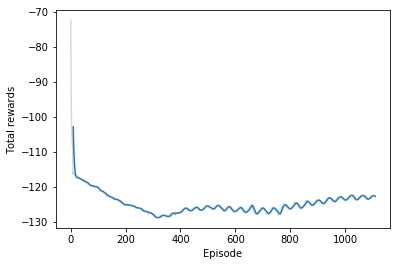

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

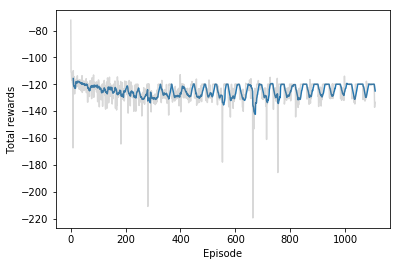

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

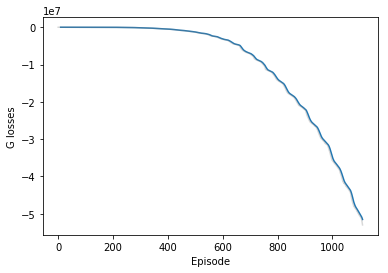

In [44]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

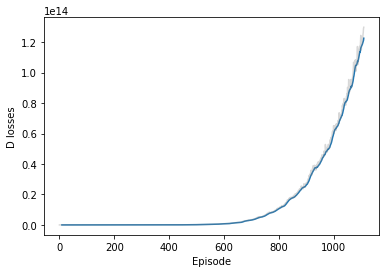

In [45]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [46]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -130.50857430583363


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.